# Feedforward Networks (FFN) and Activation Functions


This notebook demonstrates how **Feedforward Neural Networks (FFNs)** work inside a Transformer, and how different **activation functions** shape the output. We’ll cover:
- FFN architecture (expand → transform → compress)
- Common activation functions (ReLU, Sigmoid, Tanh, GELU, Swish)
- Math visualization of $Wx+b$ and activations


## What is a Feedforward Network (FFN)?

A **Feedforward Neural Network** is a core component of the Transformer architecture that processes each position independently:

**Architecture**: Input → Linear Layer (expand) → Activation → Linear Layer (compress) → Output

**Key Properties**:
- **Position-wise**: Same FFN applied to each token position
- **Expansion-Compression**: Typically expands to 4× the input dimension, then compresses back
- **Non-linearity**: Activation functions enable complex transformations

In Transformers: **Attention captures relationships** between positions, **FFN transforms** each position's representation.

## Why Do We Need Activation Functions?

Without activation functions, neural networks would just be linear transformations:
- **Linear layers alone**: `f(g(x)) = W₂(W₁x + b₁) + b₂ = W'x + b'`
- **With activations**: Enable non-linear mappings and complex function approximation

**Key Benefits**:
- **Non-linearity**: Break linearity to learn complex patterns
- **Universal Approximation**: Can approximate any continuous function
- **Feature Learning**: Each layer learns increasingly abstract representations

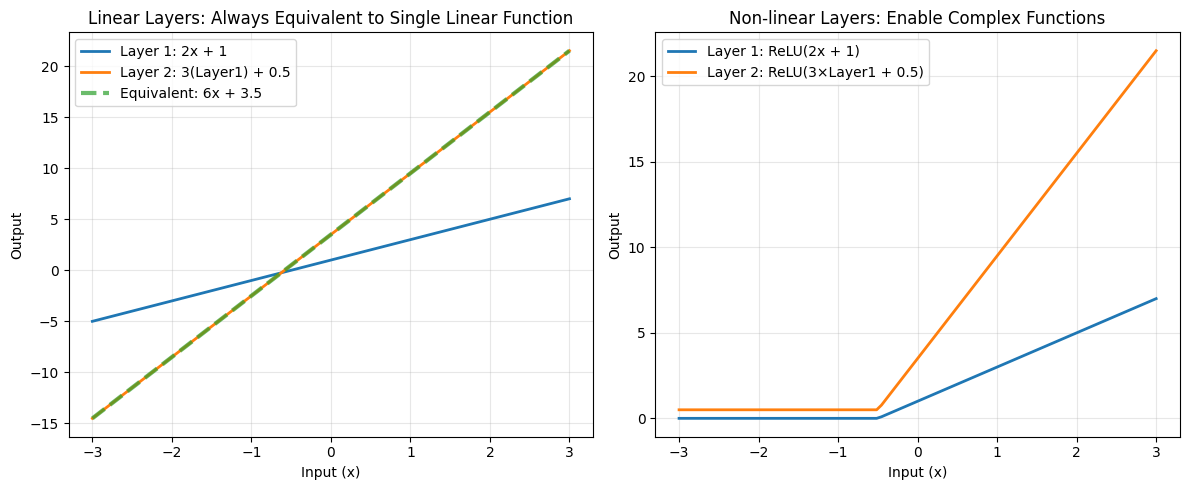

Key Insight: Without activation functions, multiple layers collapse to a single linear transformation!


In [6]:
# Visual demonstration: Linear vs Non-linear transformations
import numpy as np
import matplotlib.pyplot as plt

# Create sample data
x = np.linspace(-3, 3, 100)

# Linear transformations
linear_1 = 2 * x + 1
linear_2 = 3 * linear_1 + 0.5  # Stacked linear layers
equivalent = 6 * x + 3.5  # Mathematically equivalent

# Non-linear transformations
nonlinear_1 = np.maximum(0, 2 * x + 1)  # ReLU activation
nonlinear_2 = np.maximum(0, 3 * nonlinear_1 + 0.5)  # ReLU after transformation

plt.figure(figsize=(12, 5))

# Linear case
plt.subplot(1, 2, 1)
plt.plot(x, linear_1, label='Layer 1: 2x + 1', linewidth=2)
plt.plot(x, linear_2, label='Layer 2: 3(Layer1) + 0.5', linewidth=2)
plt.plot(x, equivalent, '--', label='Equivalent: 6x + 3.5', alpha=0.7, linewidth=3)
plt.title('Linear Layers: Always Equivalent to Single Linear Function')
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.legend()
plt.grid(True, alpha=0.3)

# Non-linear case
plt.subplot(1, 2, 2)
plt.plot(x, nonlinear_1, label='Layer 1: ReLU(2x + 1)', linewidth=2)
plt.plot(x, nonlinear_2, label='Layer 2: ReLU(3×Layer1 + 0.5)', linewidth=2)
plt.title('Non-linear Layers: Enable Complex Functions')
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Insight: Without activation functions, multiple layers collapse to a single linear transformation!")

## FFN Structure and Dimensions

Let's examine the typical FFN structure used in Transformers:

```
Input (d_model) → Linear₁ (d_ff) → Activation → Linear₂ (d_model) → Output
     512       →    2048       →     ReLU    →    512     →   512
```

**Key Points**:
- **Expansion Ratio**: Usually 4:1 (d_ff = 4 × d_model)  
- **Parameter Count**: Most parameters in Transformers are in FFN layers
- **Computational Cost**: FFN is computationally expensive due to large intermediate dimension

## Building Blocks: From Single Neuron to FFN

Before diving into complex FFNs, let's understand the fundamental operations:

=== Single Neuron Demonstration ===
Inputs: [-2 -1  0  1  2]
Weight: 0.5, Bias: 1.0
Linear output (Wx + b): [0.  0.5 1.  1.5 2. ]
With ReLU activation: [0.  0.5 1.  1.5 2. ]


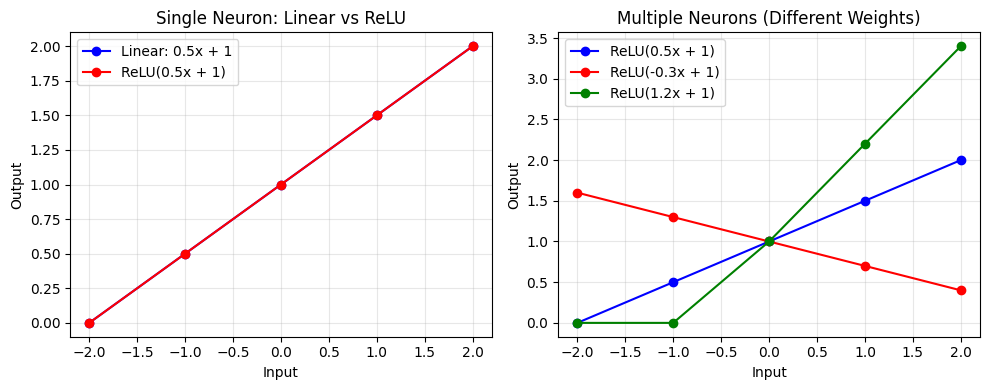

In [7]:
# Single Neuron: The foundation of neural networks
# A neuron computes: output = activation(weight * input + bias)

def single_neuron(x, weight, bias, activation_fn=None):
    """Simulate a single neuron"""
    linear_output = weight * x + bias
    if activation_fn:
        return activation_fn(linear_output)
    return linear_output

# Example with different inputs and weights
inputs = np.array([-2, -1, 0, 1, 2])
weight = 0.5
bias = 1.0

print("=== Single Neuron Demonstration ===")
print(f"Inputs: {inputs}")
print(f"Weight: {weight}, Bias: {bias}")

# Linear output (no activation)
linear_out = single_neuron(inputs, weight, bias)
print(f"Linear output (Wx + b): {linear_out}")

# With ReLU activation
relu_out = single_neuron(inputs, weight, bias, relu)
print(f"With ReLU activation: {relu_out}")

# Visualize
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(inputs, linear_out, 'bo-', label='Linear: 0.5x + 1')
plt.plot(inputs, relu_out, 'ro-', label='ReLU(0.5x + 1)')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Single Neuron: Linear vs ReLU')
plt.legend()
plt.grid(True, alpha=0.3)

# Show multiple neurons (different weights)
plt.subplot(1, 2, 2)
weights = [0.5, -0.3, 1.2]
colors = ['blue', 'red', 'green']

for i, w in enumerate(weights):
    output = single_neuron(inputs, w, bias, relu)
    plt.plot(inputs, output, 'o-', color=colors[i], label=f'ReLU({w}x + 1)')

plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Multiple Neurons (Different Weights)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Matrix Operations: Multiple Neurons Working Together

Now let's see how multiple neurons work together using matrix operations:

=== Multi-Layer Network Forward Pass ===
Input: [ 1.  -0.5  2. ]
Input shape: (3,)
Hidden layer (linear): [-1.49718909 -1.15752427  0.30794261 -1.54321665]
Hidden layer (ReLU): [0.         0.         0.30794261 0.        ]
Final output: [0.27484499 0.143417  ]


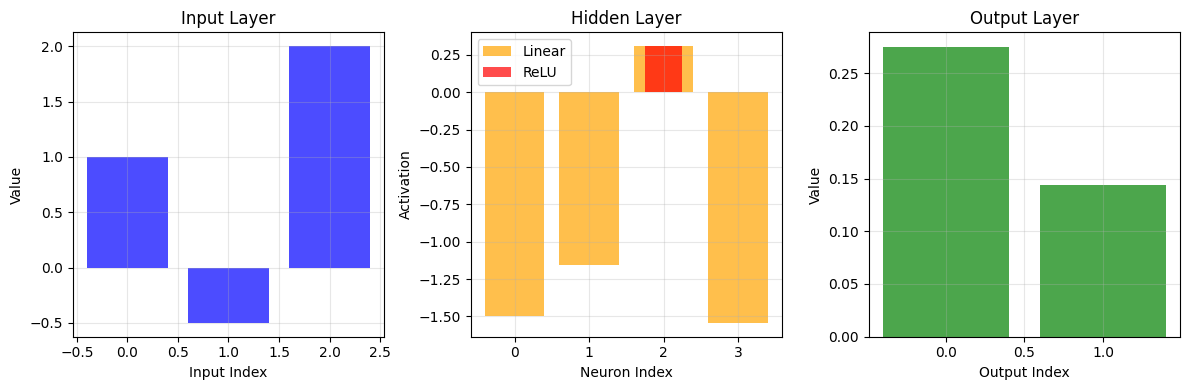

\nMatrix dimensions:
W1: (4, 3) (hidden × input)
W2: (2, 4) (output × hidden)
This is how FFNs scale to large networks!


In [8]:
# Matrix operations: How multiple neurons work together
# Input vector: x = [x1, x2, x3]
# Weight matrix: W where each row is a neuron's weights
# Output: y = activation(W @ x + b)

def layer_forward(x, W, b, activation_fn=None):
    """Forward pass through a layer"""
    z = W @ x + b  # Linear transformation
    if activation_fn:
        return activation_fn(z)
    return z

# Example: 3 inputs -> 4 hidden neurons -> 2 outputs
input_size = 3
hidden_size = 4
output_size = 2

# Sample input
x = np.array([1.0, -0.5, 2.0])

# Layer 1: input -> hidden
W1 = np.random.randn(hidden_size, input_size) * 0.5
b1 = np.zeros(hidden_size)

# Layer 2: hidden -> output  
W2 = np.random.randn(output_size, hidden_size) * 0.5
b2 = np.zeros(output_size)

print("=== Multi-Layer Network Forward Pass ===")
print(f"Input: {x}")
print(f"Input shape: {x.shape}")

# Forward pass
h1 = layer_forward(x, W1, b1)  # Linear
print(f"Hidden layer (linear): {h1}")

h1_activated = layer_forward(x, W1, b1, relu)  # With ReLU
print(f"Hidden layer (ReLU): {h1_activated}")

output = layer_forward(h1_activated, W2, b2)  # Final output
print(f"Final output: {output}")

# Visualize the transformation
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(range(len(x)), x, color='blue', alpha=0.7)
plt.title('Input Layer')
plt.xlabel('Input Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.bar(range(len(h1)), h1, color='orange', alpha=0.7, label='Linear')
plt.bar(range(len(h1_activated)), h1_activated, color='red', alpha=0.7, label='ReLU', width=0.5)
plt.title('Hidden Layer')
plt.xlabel('Neuron Index')
plt.ylabel('Activation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(range(len(output)), output, color='green', alpha=0.7)
plt.title('Output Layer')
plt.xlabel('Output Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\\nMatrix dimensions:")
print(f"W1: {W1.shape} (hidden × input)")
print(f"W2: {W2.shape} (output × hidden)")
print(f"This is how FFNs scale to large networks!")

## Imports and Setup

Let's import the necessary libraries for our FFN and activation function exploration:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# Define activation functions for comparison
def relu(x): return np.maximum(0, x)
def sigmoid(x): return 1/(1+np.exp(-np.clip(x, -500, 500)))  # Clipped to prevent overflow
def tanh(x): return np.tanh(x)
def gelu(x): return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))
def swish(x, beta=1.0): return x * sigmoid(beta*x)

## Activation Functions: Properties and Trade-offs

Let's explore why different activation functions exist and their key properties:

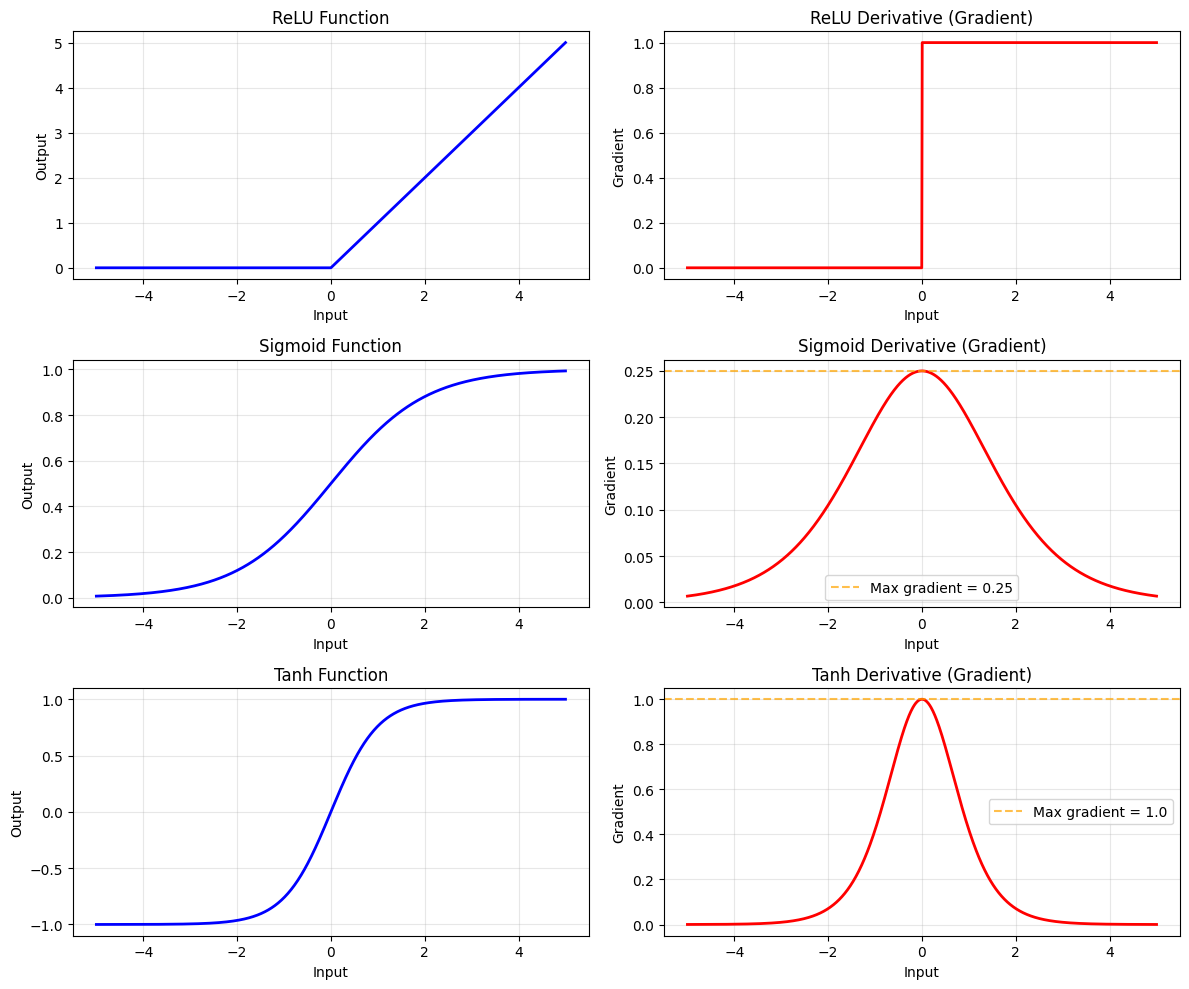

Key Properties:
• ReLU: Simple, fast, but can cause 'dead neurons' (gradient = 0 for x < 0)
• Sigmoid: Smooth, but saturates (small gradients) for large |x|
• Tanh: Zero-centered, but also saturates
• GELU/Swish: Smooth approximations to ReLU, better gradient flow


In [11]:
# Let's examine key properties of activation functions
def plot_activation_properties():
    x = np.linspace(-5, 5, 1000)
    
    # Define activation functions with their derivatives
    def relu_and_derivative(x):
        return np.maximum(0, x), (x > 0).astype(float)
    
    def sigmoid_and_derivative(x):
        s = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        return s, s * (1 - s)
    
    def tanh_and_derivative(x):
        t = np.tanh(x)
        return t, 1 - t**2
    
    functions = {
        'ReLU': relu_and_derivative,
        'Sigmoid': sigmoid_and_derivative,
        'Tanh': tanh_and_derivative
    }
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    
    for i, (name, func) in enumerate(functions.items()):
        y, dy = func(x)
        
        # Function plot
        axes[i, 0].plot(x, y, linewidth=2, color='blue')
        axes[i, 0].set_title(f'{name} Function')
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_xlabel('Input')
        axes[i, 0].set_ylabel('Output')
        
        # Derivative plot
        axes[i, 1].plot(x, dy, linewidth=2, color='red')
        axes[i, 1].set_title(f'{name} Derivative (Gradient)')
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].set_xlabel('Input')
        axes[i, 1].set_ylabel('Gradient')
        
        # Highlight gradient issues
        if name == 'Sigmoid':
            axes[i, 1].axhline(y=0.25, color='orange', linestyle='--', alpha=0.7, label='Max gradient = 0.25')
            axes[i, 1].legend()
        elif name == 'Tanh':
            axes[i, 1].axhline(y=1.0, color='orange', linestyle='--', alpha=0.7, label='Max gradient = 1.0')
            axes[i, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Key Properties:")
    print("• ReLU: Simple, fast, but can cause 'dead neurons' (gradient = 0 for x < 0)")
    print("• Sigmoid: Smooth, but saturates (small gradients) for large |x|")
    print("• Tanh: Zero-centered, but also saturates")
    print("• GELU/Swish: Smooth approximations to ReLU, better gradient flow")

plot_activation_properties()

## Activation Function Comparison

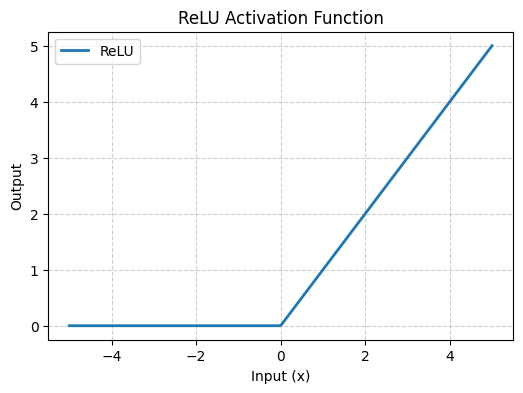

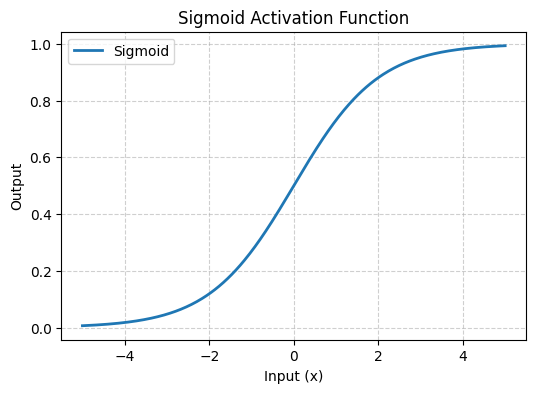

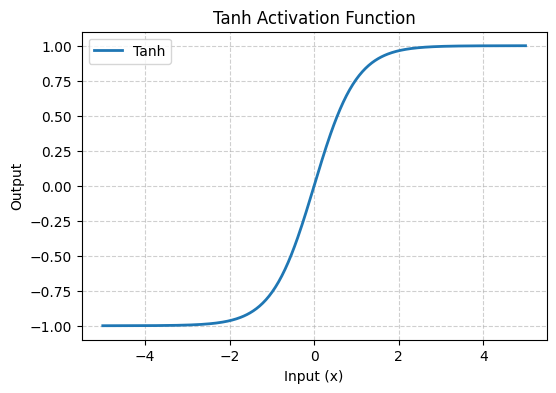

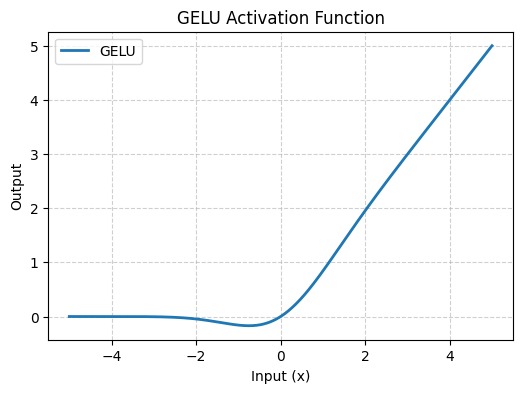

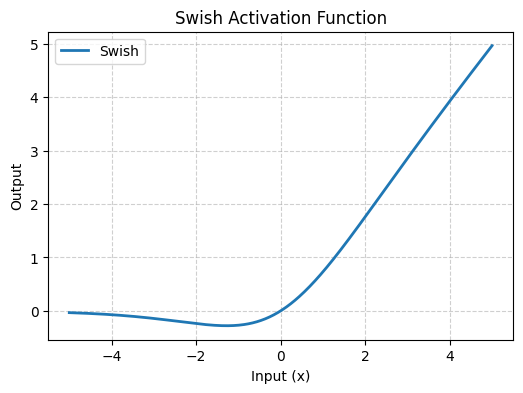

In [12]:
x = np.linspace(-5,5,400)
functions = {
    'ReLU': relu(x),
    'Sigmoid': sigmoid(x),
    'Tanh': tanh(x),
    'GELU': gelu(x),
    'Swish': swish(x)
}

for name, y in functions.items():
    plt.figure(figsize=(6,4))
    plt.plot(x,y,label=name,linewidth=2)
    plt.title(f"{name} Activation Function")
    plt.xlabel("Input (x)")
    plt.ylabel("Output")
    plt.grid(True,linestyle="--",alpha=0.6)
    plt.legend()
    plt.show()

## Feedforward Network in PyTorch

In [13]:
class FFN(nn.Module):
    def __init__(self, d_model=8, d_ff=32, activation=nn.GELU):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = activation()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.activation(self.linear1(x)))

# Example
ffn = FFN(d_model=4, d_ff=16)
x = torch.randn(2,4)
print("Input:\n",x)
print("Output:\n",ffn(x))

Input:
 tensor([[-0.1408,  1.2428,  1.6317, -0.8046],
        [ 1.1190,  0.6337, -0.0070,  1.2147]])
Output:
 tensor([[ 0.1581, -0.0555,  0.0073, -0.1702],
        [-0.0929,  0.1725,  0.0781, -0.0574]], grad_fn=<AddmmBackward0>)
Output:
 tensor([[ 0.1581, -0.0555,  0.0073, -0.1702],
        [-0.0929,  0.1725,  0.0781, -0.0574]], grad_fn=<AddmmBackward0>)


## Math Visualization: $Wx+b$ and Activations

Input x: [-2 -1  0  1  2]
Weights W:
 [[0.5]
 [1. ]]
Bias b:
 [[0. ]
 [0.5]]
Linear output (Wx+b):
 [[-1.  -0.5  0.   0.5  1. ]
 [-1.5 -0.5  0.5  1.5  2.5]]
After ReLU:
 [[0.  0.  0.  0.5 1. ]
 [0.  0.  0.5 1.5 2.5]]


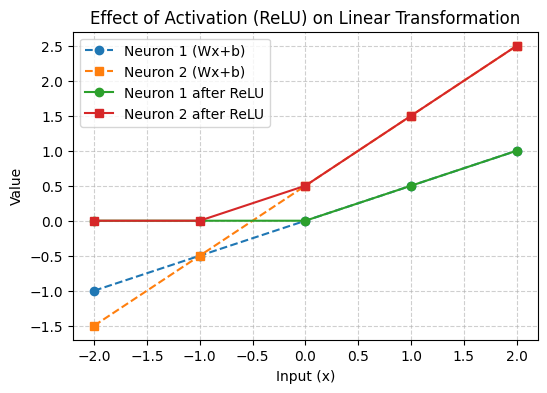

In [14]:
x = np.array([-2,-1,0,1,2])
W = np.array([[0.5],[1.0]])  # 1 input → 2 hidden units
b = np.array([[0.0],[0.5]])

z = W @ x.reshape(1,-1) + b  # linear transformation

print("Input x:", x)
print("Weights W:\n", W)
print("Bias b:\n", b)
print("Linear output (Wx+b):\n", z)

# Apply ReLU
a = relu(z)
print("After ReLU:\n", a)

# Plot
plt.figure(figsize=(6,4))
plt.plot(x, z[0], 'o--', label='Neuron 1 (Wx+b)')
plt.plot(x, z[1], 's--', label='Neuron 2 (Wx+b)')
plt.plot(x, a[0], 'o-', label='Neuron 1 after ReLU')
plt.plot(x, a[1], 's-', label='Neuron 2 after ReLU')
plt.xlabel("Input (x)")
plt.ylabel("Value")
plt.title("Effect of Activation (ReLU) on Linear Transformation")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()